In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as trans
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from utils0 import *
from style_utils import *

def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.transpose(1, 2, 0))
    return

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# load pretrained loss network, only need feature parts
loss_net = torchvision.models.squeezenet1_1(pretrained=True).features
loss_net.type(dtype)

for param in loss_net.parameters():
    param.requires_grad = False

# load pretrained GANs
G_c = dc_generator()
G_c.load_state_dict(torch.load('./savemodels/pretrained_gan_64/G_9000.pkl'))
G_c.type(dtype)
for param in G_c.parameters():
    param.requires_grad = False

G_s = dc_generator()
G_s.load_state_dict(torch.load('./savemodels/pretrained_gan_64/G_9000.pkl'))
G_s.type(dtype)
for param in G_s.parameters():
    param.requires_grad = True

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [3]:
def train_style(g_c, g_s, batchsize, noize_dim, style_target, style_size, loss_net, 
                style_layers, style_weights, content_layer, content_weight, tv_weight):
    
    # load style target
    style_img = style_target_preprocess(PIL.Image.open(style_target), size=style_size)
    style_img = style_img.type(dtype)
    style_feats = extract_features(style_img, loss_net)
    style_grams = []
    for idx in style_layers:
        style_grams.append(gram_matrix(style_feats[idx].clone()))

    # Set up optimization hyperparameters
    initial_lr = 1e-4
    #decayed_lr = 
    #decay_lr_at = 

    optimizer = torch.optim.Adam(g_s.parameters(), lr=initial_lr) # hyperparameters TBD

    for t in range(51):
        optimizer.zero_grad()

        # sample latent variable
        z = sample_noise(batchsize, noize_dim).type(dtype)

        fake_contents = g_c(z).detach()
        fake_images = g_s(z)

        content_target = extract_features(fake_contents, loss_net)
        content_target = content_target[content_layer].clone()
        fake_feats = extract_features(fake_images, loss_net)
        
        # Compute loss
        c_loss = content_loss(content_weight, fake_feats[content_layer], content_target)
        s_loss = style_loss(fake_feats, style_layers, style_grams, style_weights)
        t_loss = tv_loss(fake_images, tv_weight)
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        #if t == decay_lr_at:
        #    optimizer = torch.optim.Adam(g_s.parameters(), lr=decayed_lr)
        
        optimizer.step()

        if t % 50 == 0:
            imgs_numpy = deprocess_img(fake_images.cpu().detach().numpy())
            show_images(imgs_numpy[0:64])
            plt.show()

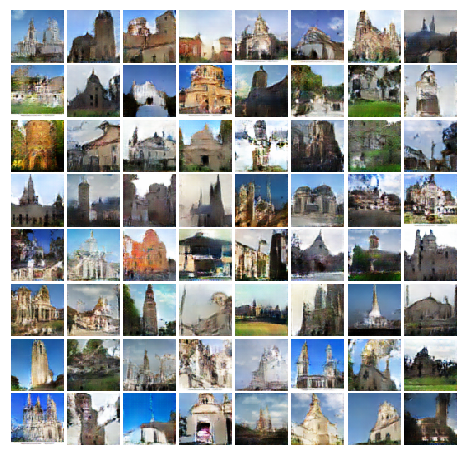

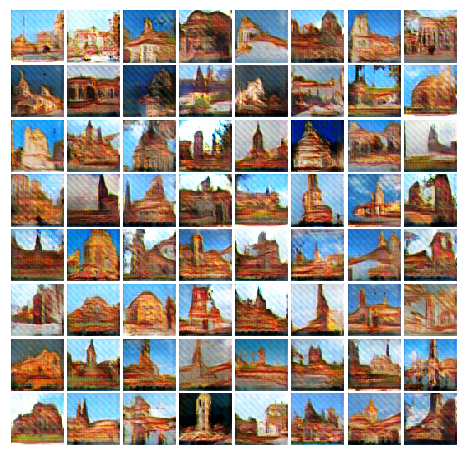

In [4]:
G_s.load_state_dict(torch.load('./savemodels/pretrained_gan_64/G_9000.pkl'))
train_style(G_c, G_s, 128, 100, './styles/the_scream.jpg', 224, loss_net, [1, 4, 6, 7], [10000, 400, 6, 0.5], 3, 3e-1, 2e-3)

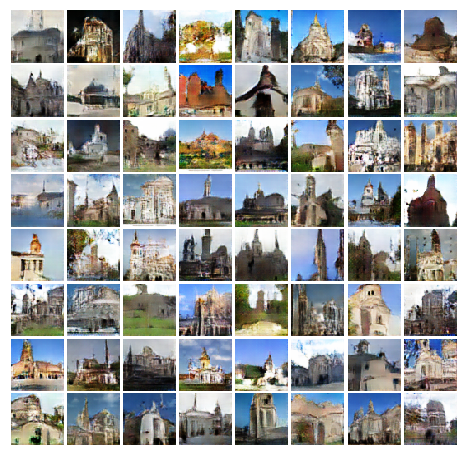

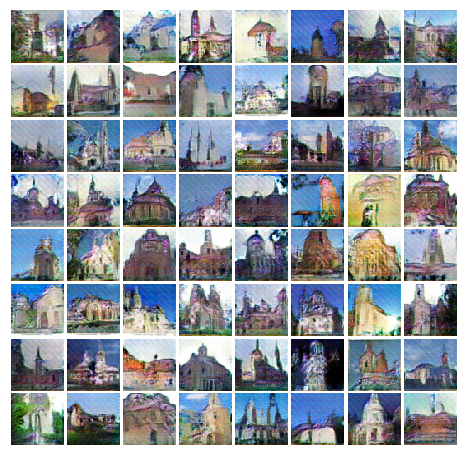

In [12]:
G_s.load_state_dict(torch.load('./savemodels/pretrained_gan_64/G_9000.pkl'))
train_style(G_c, G_s, 128, 100, './styles/starry_night.jpg', 224, loss_net, [1, 4, 6, 7], [5000, 40, 1, 0.5], 3, 3e-1, 2e-2)